In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from scipy.stats import gamma, uniform

In [3]:
disasters = genfromtxt('disasters.csv', delimiter = ',')

#Calculate transition probability, based on random walk proposal
def calc_probability_random_walk(tau, breakpoints_current, breakpoints_propose, labda):
    if np.all(breakpoints_propose[:-1] < breakpoints_propose[1:]) or np.all(breakpoints_current[:-1] < breakpoints_current[1:]):
        return 0
    else:
        nt_current = np.histogram(tau, bins = breakpoints_current)[0].astype('int32')
        nt_propose = np.histogram(tau, bins = breakpoints_propose)[0].astype('int32')
        
        log_prob_current = -np.sum(lambdas*np.diff(breakpoints_current)) + np.sum(nt_current*np.log(labda))
        log_prob_propose = -np.sum(lambdas*np.diff(breakpoints_propose)) + np.sum(nt_propose*np.log(labda))
        
        return np.exp(log_prob_propose - log_prob_current)

#Propose moving one single breakpoint
def proposal_random_walk(breakpoints, index, rho):
    ti = breakpoints[index]
    R = rho*(breakpoints[index+1] - breakpoints[index-1])
    epsilon = np.random.uniform(-R, R)
    ti_proposal = ti+epsilon

    breakpoints_propose = np.copy(breakpoints)
    breakpoints_propose[index] = ti_proposal
    
    return breakpoints_propose

def sample_lambda(tau, theta, t, num_berakpoints):
    #code here
    
    return theta
    
def sample_theta(tau, labda, t, num_breakpoints):
    #code here
    
    return labda
    
    
def init_mcmc(N, num_breakpoints, psi, rho, burn_in = 0, print_debug = False):
    
    #Initial burn in attempts if needed
    M = N + burn_in
    
    #Initialize arrays
    breakpoints = np.zeros((M, num_breakpoints + 2))
    breakpoints[0] = np.arange(1658,1981, (1980-1658)/(num_breakpoints+1))
    tau = disasters  

    #Arrays to save values of lambda and theta
    lambdas = np.zeros((M, num_breakpoints + 1))
    thetas = np.zeros((M, num_breakpoints + 1))
    
    #Array to save MH probability
    probs = np.zeros(M)
    
    #Initialize theta and lambda by prior distribution
    thetas[0] = gamma(2, psi).rvs(num_breakpoints + 1)
    for interval in range(num_breakpoints + 1):
        lambdas[0, interval] = gamma(2, thetas[0, interval]).rvs(1)
    
    #Main loop
    for index in range(M - 1):
        
        #Gibbs sampling
        thetas[index + 1] = sample_theta(tau, thetas[index], breakpoints[index], num_breakpoints)
        lambdas[index + 1] = sample_lambda(tau, lambdas[index], breakpoints[index], num_breakpoints)
            
        if print_debug:
            print(f'Iter: {index}')
            print(f' Theta: {thetas[index]}')
            print(f' Lambda: {lambdas[index]}')
        
        
        #Random walk proposal for breakpoints (MH Sampling)
        breakpoints_propose = np.copy(breakpoints[index])
        
        #Propose one breakpoint at a time
        for t in np.arange(num_breakpoints) + 1:
            
            #Propose new breakpoint
            breakpoints_propose = proposal_random_walk(breakpoints_propose, t, rho)

        #Probability of accept
        probs[index] = calc_probability_random_walk(tau, breakpoints[index], breakpoints_propose, lambdas[index])

        accept = np.random.uniform(0,1) < probs[index]

        if print_debug:
            print(f'Breakpoint {t}')
            print(f' Current breakpoints: {breakpoints}')
            print(f' Proposed breakpoints: {breakpoints_propose}')
            print(f' P(accept) = {p_accept}')
            print(f' Accept: {accept}')

        if accept:
            breakpoints[index + 1] = np.copy(breakpoints_propose)
        else:
            breakpoints[index+1] = np.copy(breakpoints[index])

    return breakpoints, lambdas, probs
    

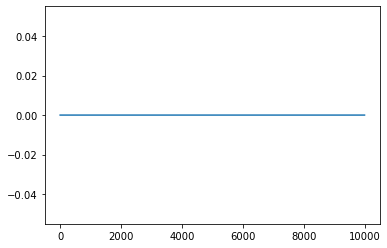

In [4]:
breakpoints, lambdas, probs = init_mcmc(N = 10**4, num_breakpoints = 2, psi = 0.001, rho = 0.5, print_debug = False)
plt.plot(probs)

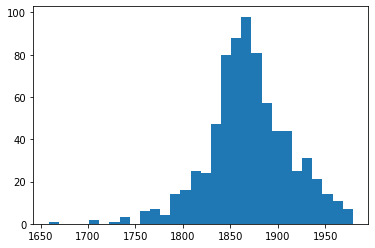

In [35]:
_ = plt.hist(disasters, bins = 'auto')